## Prediction Taxi Orders

The Taxi company has collected historical data on taxi orders at airports. In order to attract more drivers during the peak period, it is necessary to predict the number of taxi orders in the next hour. Build a model for such a prediction.


#### Prepare data

In [1]:
import pandas as pd 
from IPython.display import display
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('taxi.csv', index_col = [0], parse_dates = [0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


- Let's see if the data is in chronological order.

In [5]:
data.index.is_monotonic

True

- Let's make resamplings for one hour

In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Now the dataframe shows the total number of taxi orders by hour.
Let's start with the analysis of the time series.

#### Analysis

- Let's decompose to check the threads and seasonality.

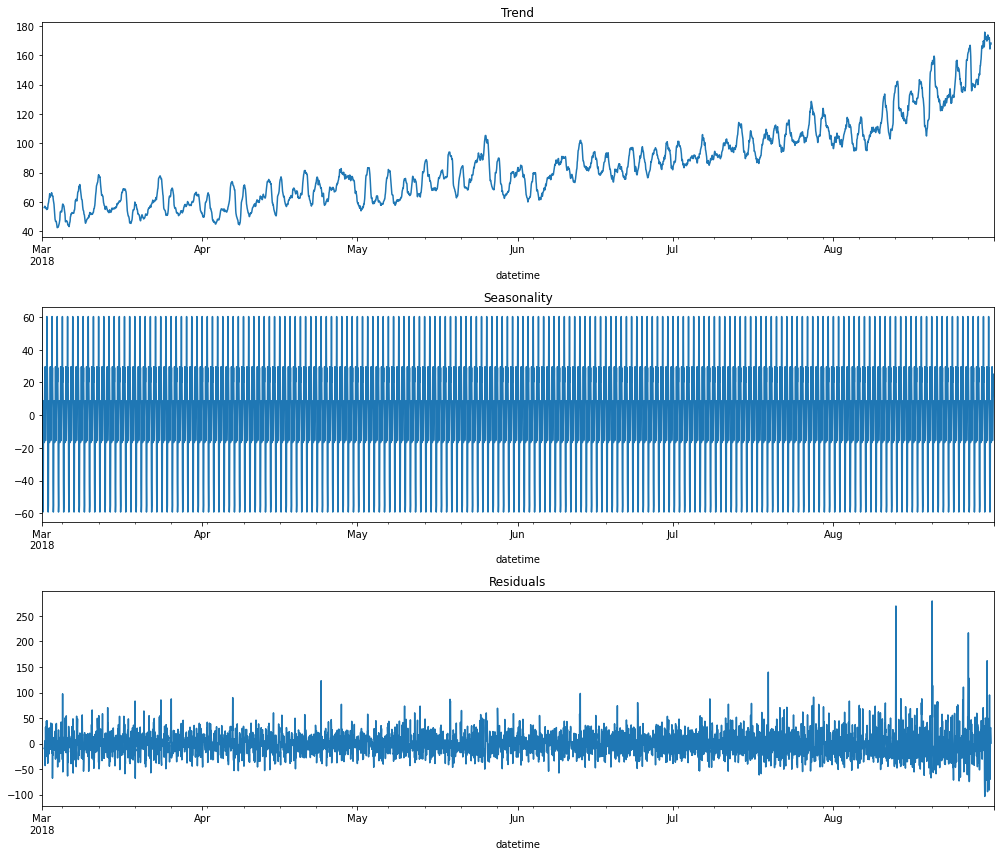

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize = (14, 12))

plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

The first graph clearly shows an increase, most likely due to the fact that more people can afford taxis. The second graph shows a stochastic stationary process, since the distribution is not related to time. 
- Let's take a closer look at the graphs for the last week and day.

In [8]:
data.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

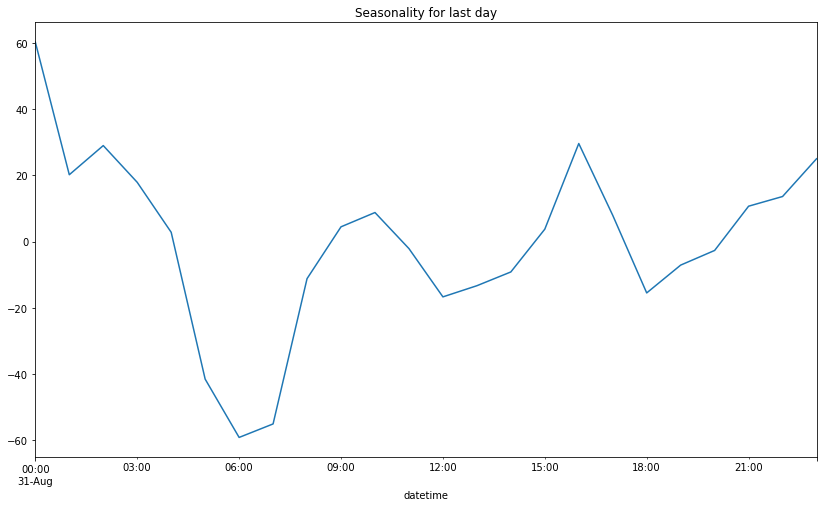

In [9]:
plt.figure(figsize = (14, 8))

decomposed.seasonal['2018-08-31'].plot()
plt.title('Seasonality for last day')
plt.show()

As expected, the dependence of the number of orders on the time of day is visible, the largest peak is from midnight to 3 am, since public transport does not work at this time. There are also peaks at 10 and 16, probably due to the flight schedule.
- Now let's look at the dependence on the days of the week.

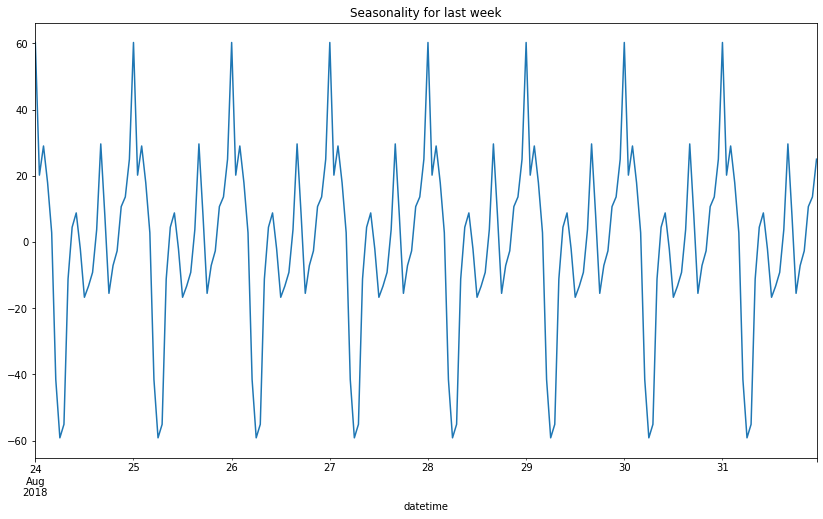

In [10]:
plt.figure(figsize = (14, 8))

decomposed.seasonal['2018-08-24' : '2018-08-31'].plot()
plt.title('Seasonality for last week')
plt.show()

We see that taxi services are needed on any day, there is no dependence.

- Now let's create features for training models. Let's add calendar features, the remaining value and the moving average.

In [11]:
def make_features(data, max_lag, rolling_mean_size) :
    data_new = data.copy()
    
    data_new['hour'] = data_new.index.hour
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
        
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
        
    return data_new

In [12]:
taxi = make_features(data, 24*7, 1)
taxi.head()

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0


- Divide the dataset into training and test sets

In [13]:
train , test = train_test_split(taxi, shuffle = False , test_size = 0.1, random_state = 12345)
train = train.dropna()

print('Train size:', train.shape)
print('Test size:', test.shape)


Train size: (3806, 173)
Test size: (442, 173)


Let's check the correctness of the division into samples, the test sample should follow the training one so that the order of the time series is not violated.

In [14]:
train.index.max()

Timestamp('2018-08-13 13:00:00', freq='H')

In [15]:
test.index.min()

Timestamp('2018-08-13 14:00:00', freq='H')

The order is not violated. We divide both samples into a feature and a target feature.

In [16]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis = 1)

target_test = test['num_orders']
features_test  = test.drop('num_orders', axis = 1)

print('The size of the feature table of the training set:', features_train.shape)
print('The size of the feature table of the test set:', features_test.shape)

The size of the feature table of the training set: (3806, 172)
The size of the feature table of the test set: (442, 172)


### Training :

Let's create the RSME function of the model .

In [17]:
def rmse(model):
    
    model.fit(features_train, target_train)
    y_pred = model.predict(features_test)
    rmse = np.sqrt(mean_squared_error(target_test, y_pred))
    
    return rmse

Since cross validation cannot be used for time series, since the target feature may leak, we will use cross validation for time series

In [18]:
tcsv = TimeSeriesSplit(n_splits = 8)

- Linear Regression 

In [19]:
model_linear = LinearRegression()
params_linear = {'fit_intercept' : [True, False],
            'normalize': [True, False]}

grid_linear = GridSearchCV(model_linear, params_linear , 
                          cv = tcsv, 
                          n_jobs = 1,
                          verbose = 0,
                          scoring = 'neg_mean_squared_error')

rmse_linear = rmse(grid_linear)
print('RMSE Linear Regression', round(rmse_linear), 'orders')

RMSE Linear Regression 35 orders


- LGBMRegressor

In [20]:
%%time
model_lgbm = LGBMRegressor()

params_lgbm = {'learning_rate' : [0.01, 0.05, 0.1],
              'n_estimators' : [100, 125, 150],
              'max_depth' : [1, 2, 3]}

grid_lgbm = GridSearchCV(model_lgbm, params_lgbm,
                        cv = tcsv,
                        n_jobs = 1,
                        verbose = 0,
                        scoring = 'neg_mean_squared_error')

rmse_lgbm = rmse(grid_lgbm)
print('RMSE LGBMRegressor', round(rmse_lgbm), 'orders')

RMSE LGBMRegressor 38 orders
CPU times: user 2min 14s, sys: 13.1 s, total: 2min 27s
Wall time: 19.4 s


- Cat Boost

In [21]:
%%time
model_cat = CatBoostRegressor(loss_function = 'RMSE', silent=True)
cat_params = {'depth' : [1, 3, 5],
             'learning_rate' : [0.01, 0.05, 0.1],
             'iterations' : [50, 75 , 100]}

grid_cat = GridSearchCV(model_cat, cat_params, 
                       cv = tcsv, 
                       n_jobs = 1,
                        verbose = 0,
                        scoring = 'neg_mean_squared_error')

rmse_cat = rmse(grid_cat)
print('Cat Boost', round(rmse_cat), 'orders')

Cat Boost 39 orders
CPU times: user 2min 35s, sys: 14.1 s, total: 2min 49s
Wall time: 33.2 s


#### Checking the quality of the models :

In [22]:
pred_previous = test.shift(fill_value = train['num_orders'].iloc[-1])
rmse_pred = np.sqrt(mean_squared_error(test, pred_previous))
print('RMSE by previous value', round(rmse_pred))

RMSE by previous value 56


In [23]:
results = {'RMSE orders' : [rmse_linear, rmse_lgbm, rmse_cat, rmse_pred]}

result_table = pd.DataFrame(results)
result_table.index = ['LinearRegression', 'LGBMRegression', 
                      'CatBoost', 'by previous value']

result_table = result_table.round(0)
display(result_table)

,RMSE orders
LinearRegression,35.0
LGBMRegression,38.0
CatBoost,39.0
by previous value,56.0


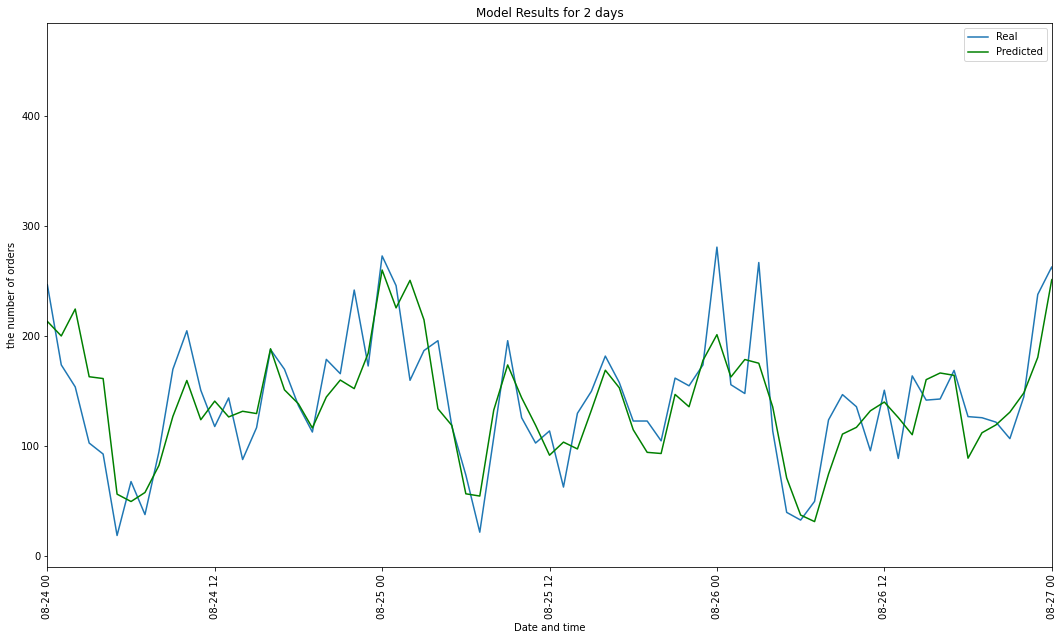

In [26]:
predictions = pd.Series(grid_linear.predict(features_test), index = target_test.index) 

fig2, ax = plt.subplots(figsize=(18, 10))
ax = sns.lineplot(data=target_test, label='Real')
sns.lineplot(data=predictions, color='green', label='Predicted')
plt.xticks(rotation=90)
#ax.set_xticklabels(features_test.dayofweek)
plt.xlim('2018-08-24', '2018-08-27') 
plt.title('Model Results for 2 days')
plt.xlabel('Date and time')
plt.ylabel('the number of orders')
plt.show();